In [1]:
# def get_from_yd(link, file_name):
#   !wget https://getfile.dokpub.com/yandex/get/$link -O $file_name

In [58]:
# import numpy as np
# np.set_printoptions(precision=2)
# import json
# from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# import pandas as pd
# import importlib
# import matplotlib.pyplot as plt
# from navec import Navec
# embedding_dir = 'temp_data/navec_hudlit_v1_12B_500K_300d_100q.tar'
# navec = Navec.load(embedding_dir)
# import os
# import glob
# from importlib import reload

# import torch
# import models 
# from importlib import reload
# reload(models);
# import models
# from models import AverageMeter

# import collections
# %matplotlib inline
# import matplotlib.pyplot as plt
# from IPython import display
# from torch import nn
# from torch import optim

import load_data
import data_utils
import torch_utils 

import importlib
importlib.reload(load_data)
importlib.reload(data_utils)
importlib.reload(torch_utils)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import glob
import json
from tqdm import tqdm

import torch
from torch import optim


In [3]:
# load_data.read_from_disk_preprocess_save(read_dir='raw_data/cases_small', save_dir='data/cases_small_preprocessedLEMM/',
#                                     lemmatize=True)

## Loading data

Checking dataset_size

In [4]:
read_dir = 'data/cases_small_preprocessedLEMM/'
Y = []
for _, y in load_data.yield_preprocessed_json_from_disk(read_dir):
    Y.append(y)

100%|█████████████████████████████████████████████████████████████████████████████████| 113/113 [00:05<00:00, 18.91it/s]


Spliting indices into train and test

In [5]:
np.random.seed(0)
DS_SIZE = len(Y)
indices = np.arange(len(Y))
train_indices, test_indices = train_test_split(indices, test_size=.2)

Mapping casenumbers to categories IDs.

In [6]:
cases_info = pd.read_csv('data/cases_info.csv')
cases_d = dict(zip(cases_info['Number'], cases_info['CategoryID']))
del cases_info

In [7]:
Y_id = np.array(list(map(lambda case: cases_d[case], Y)))

Skipping indices that are not labeled. And creating a maping from categoryID to categoryIndex

In [8]:
skip_indices = set(np.where(Y_id == -1)[0])
keep_mask = (Y_id != -1)

id2i = dict(zip(set(Y_id[keep_mask]), range(len(set(Y_id[keep_mask])))))
i2id = {v:k for k, v in id2i.items()}

train_indices=np.array(list(set(train_indices) - skip_indices))
test_indices = np.array(list(set(test_indices) - skip_indices))

Creating train corpus for tfidf vectorizer

In [12]:
def save_train_corpus(save_dir):
    """
    
    """
    load_data.mkdir(save_dir)
    train_indices_set = set(train_indices)
    for j, (x_str, y_casenumber) in enumerate(
                        load_data.yield_preprocessed_json_from_disk(read_dir)):
        if j in train_indices_set:
            y_id = cases_d[y_casenumber]
            y_i = id2i[y_id]
            i_path = os.path.join(save_dir, f'{y_i}.txt')
            with open(i_path, 'a') as f:
                f.write(x_str)
                f.write(' ')
save_train_corpus('temp_data/train_corpusSMALL_LEMM')

100%|█████████████████████████████████████████████████████████████████████████████████| 113/113 [00:10<00:00, 11.29it/s]


Iniitializing vectorizer to read from disk

In [14]:
vectorizer = TfidfVectorizer(
    input='filename',
    ngram_range=(1,2),
    max_df=.95, 
    min_df=.001,
    tokenizer=None
                            )
# # max_df :: # ignoring terms that occur more then in {max_df} % documents (or categories)
# # min_df :: # ignoring terms that occur less then in {min_df} % documents (or categories)
filelist = sorted(
    glob.glob('temp_data/train_corpusSMALL_LEMM/*'), 
    key=lambda x: int(x.split('/')[-1].split('.')[0])
)

filelist[:3]

['temp_data/train_corpusSMALL_LEMM/0.txt',
 'temp_data/train_corpusSMALL_LEMM/1.txt',
 'temp_data/train_corpusSMALL_LEMM/2.txt']

Fitting the vectorizer

In [15]:
import time
start = time.time()
S = vectorizer.fit_transform(filelist)
end = time.time()
print(f'APPROX FIT TIME (s):: {round(end - start)}')

APPROX FIT TIME (s):: 156


Extracting fixed K relevant indices from train corpus

In [16]:
def get_relevant_indices(S, k):
    """
    For each category takes top k features (features with the highest values)
    """
    n_categories = S.shape[0]
    indices = set()
    for i in range(n_categories):
        category_scores = np.array(S[i].todense())[0]
        sort_idx = np.argsort(category_scores)[::-1]
        zero_mask = np.isclose(category_scores[sort_idx], 0)
        sort_idx_cut = sort_idx[~zero_mask][:k]
        indices.update(set(sort_idx_cut))
    
    return np.sort(np.array(list(indices)))

In [17]:
start = time.time()
K = 20
rel_indices = get_relevant_indices(S, K)
print(f'NUMBER OF FEATURES (EMB DIM) :: {len(rel_indices)}')
S_d = np.array(S[:, rel_indices].todense())
set_rel_indices = set(rel_indices)
features = (
    np.array(list(
        (map(lambda x: x[1], 
            sorted(
                [(idx, f) for f, idx in vectorizer.vocabulary_.items() if idx in set_rel_indices],
                key=lambda x: x[0]
            )
        ))
    ))
)
f_to_idx = dict(zip(features, range(len(features))))
idf_measures = vectorizer.idf_[rel_indices]
end = time.time()
print(f'APPROX CELL EXEC TIME (s):: {round(end - start)}')

NUMBER OF FEATURES (EMB DIM) :: 527
APPROX CELL EXEC TIME (s):: 2


In [20]:
np.save('temp_data/S_FIXED.npy', S_d)

with open('temp_data/featuresSMALL_FIXED.json', 'w') as f:
    json.dump(list(features), f)
    
cat_ids = np.array([i2id[i] for i in range(len(i2id))])

np.save('temp_data/catIDs_FIXED.npy', cat_ids)

#### String2VEC
Creating numeric X

In [21]:
def doc_to_vector(doc_counts, f_to_idx, idf_v, use_idf=True):
    n_words = sum(doc_counts.values())
    tf_v = np.zeros(len(f_to_idx))
    for t in doc_counts:  # t is for term
        f_idx = f_to_idx.get(t, None)
        if f_idx is not None:
            tf = (doc_counts[t] 
            / n_words
                )
            tf_v[f_idx] = tf
            
    if use_idf:
        return tf_v*idf_v
    else:
        return tf_v

In [22]:
def weight_doc_vec(S, x):
    EPS = 1e-9
    distances = np.linalg.norm(S - x, axis=1)
    similarities = 1 / (distances + EPS)
    p = similarities / np.linalg.norm(similarities, ord=1)
    return p.T@S

In [27]:
read_dir = 'data/cases_small_preprocessedLEMM/'
X = []
for x_str, _ in load_data.yield_preprocessed_json_from_disk(read_dir):
    doc_counts = data_utils.build_count_dict(x_str.split(' '))
    doc_vec = doc_to_vector(doc_counts, f_to_idx, idf_measures, use_idf=True)
    ### MAKSE SURE YOU NOTICE NEXT LINE #########
#     doc_vec = weight_doc_vec(S_d, doc_vec)
    #############################################
    X.append(doc_vec)
X = np.vstack(X)

100%|█████████████████████████████████████████████████████████████████████████████████| 113/113 [00:26<00:00,  4.22it/s]


Train Test Split

In [32]:
# X_train = X[train_indices]
# X_test = X[test_indices]
# Y_train_id = Y_id[train_indices]
# Y_test_id = Y_id[test_indices]

# Y_train_i = np.array(list(map(
#     lambda x: id2i[x],
#     Y_train_id
# )))
# Y_test_i = np.array(list(map(
#     lambda x: id2i[x],
#     Y_test_id
# )))

# X_train_t = torch.Tensor(X_train)
# X_test_t = torch.Tensor(X_test)

# Y_train_it = torch.Tensor(Y_train_i).type(torch.long)
# Y_test_it = torch.Tensor(Y_test_i).type(torch.long)


(train_indices, test_indices, X_train, X_test, Y_train_id, Y_test_id,
            Y_train_i, Y_test_i, X_train_t, X_test_t, Y_train_it, Y_test_it
) = torch_utils.custom_train_test_split2(X, Y_id)

Network Configuations

In [34]:
# INPUT_DIM = X_train_t.shape[-1]
# print(f'INPUT_DIM : {INPUT_DIM}')
# OUTPUT_DIM = len(np.unique(np.concatenate((Y_train_i, Y_test_i))))  # _classes
# print(f'OUTPUT_DIM : {OUTPUT_DIM}')

# BATCH_SIZE = 2**12
# print(f'BATCH_SIZE : {BATCH_SIZE}')

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# print(DEVICE)

# # linear_model = models.LinearModelCustom2(INPUT_DIM, OUTPUT_DIM)
# # linear_model = models.LinearModel(INPUT_DIM, OUTPUT_DIM)
# model = models.MLP2(INPUT_DIM, OUTPUT_DIM)
# model.to(DEVICE)

# HISTORY = collections.defaultdict(list)

INPUT_DIM, OUTPUT_DIM, BATCH_SIZE, DEVICE, model, HISTORY = torch_utils.network_configs2(X_train_t, 
                                                                          Y_train_i, Y_test_i, 
                                                                                   verbose=True)

INPUT_DIM : 527
OUTPUT_DIM : 36
BATCH_SIZE : 4096
cpu


### Training

In [37]:
# optimizer = optim.SGD(linear_model.parameters(), lr=1e-2, momentum=0.1, nesterov=True, weight_decay=1e-1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

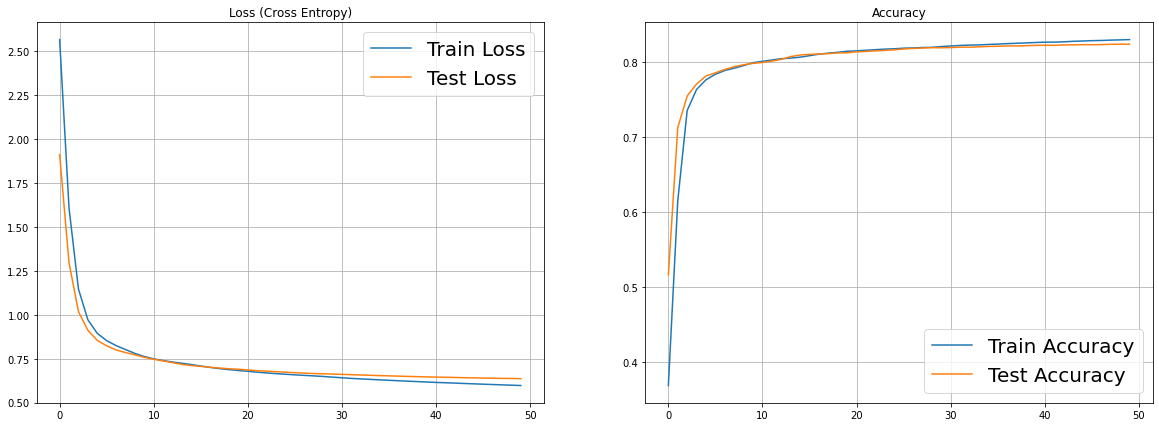

In [39]:
model, HISTORY, test_accuracy_meter= (
    torch_utils.train(
        NUM_EPOCH = 50,
        BATCH_SIZE = BATCH_SIZE,
        DEVICE = DEVICE,
        optimizer = optimizer,
        HISTORY = HISTORY,
        X_train=X_train_t, Y_train=Y_train_it,
        X_test=X_test_t, Y_test=Y_test_it,
        model = model, 
        verbose=True)
)

In [40]:
test_accuracy_meter.avg

0.8241691844803947

## Analyzing mistakes 

In [44]:
read_dir = 'data/cases_small_preprocessedLEMM/'
Z_len_m = []
Z_len = []
for i, (x_str, y) in enumerate(load_data.yield_preprocessed_json_from_disk(read_dir)):
    if i in test_indices:
        doc_counts = data_utils.build_count_dict(x_str.split(' '))
        doc_vec = doc_to_vector(doc_counts, f_to_idx, idf_measures, use_idf=True)
        
        y_id = cases_d[y]
        y_idx = id2i[y_id]  
        
        with torch.no_grad():
            logits = model.forward(torch.Tensor(doc_vec[None]))
            prediction = torch.argmax(logits, 1).item()
        
        n_tokens = len(x_str.split())
        
        if prediction != y_idx:
            
            Z_len_m.append(n_tokens)
        else:
            Z_len.append(n_tokens)
#             print(f'n_tokens :: {n_tokens}')
#             print('==========================')
#             print(x_str)
#             print('==========================')
#             break

Z_len = np.sort(Z_len)
Z_len_m = np.sort(Z_len_m)


100%|█████████████████████████████████████████████████████████████████████████████████| 113/113 [00:17<00:00,  6.54it/s]


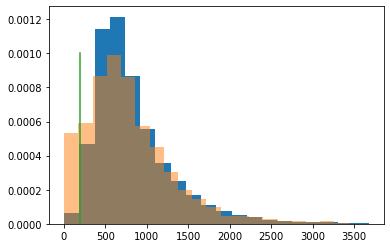

In [47]:
# Z_len = np.array(Z_len)

plt.hist(Z_len[:-100], density=True, bins=20);
plt.hist(Z_len_m[:-20], density=True, bins=20, alpha=.5)
plt.plot(np.linspace(0, 0.001)*0 + 200, np.linspace(0, 0.001))

#### Conclusion ::
We make a lot of mistakes when length of document is less then 200 in tokens.

## Several runs metrics

In [54]:
N_trials = 10
accuracy_list = []
for _ in tqdm(range(N_trials)):
    (train_indices, test_indices, X_train, X_test, Y_train_id, Y_test_id,
            Y_train_i, Y_test_i, X_train_t, X_test_t, Y_train_it, Y_test_it
    ) = torch_utils.custom_train_test_split2(X, Y_id)
    INPUT_DIM, OUTPUT_DIM, BATCH_SIZE, DEVICE, model, HISTORY = torch_utils.network_configs2(X_train_t, 
                                                                          Y_train_i, Y_test_i, 
                                                                                   verbose=False)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    
    model, HISTORY, test_accuracy_meter= (
    torch_utils.train(
        NUM_EPOCH = 10,
        BATCH_SIZE = BATCH_SIZE,
        DEVICE = DEVICE,
        optimizer = optimizer,
        HISTORY = HISTORY,
        X_train=X_train_t, Y_train=Y_train_it,
        X_test=X_test_t, Y_test=Y_test_it,
        model = model, 
        verbose=False)
    )
    
    accuracy_list.append(test_accuracy_meter.avg)
accuracy_array = np.array(accuracy_list)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.88s/it]


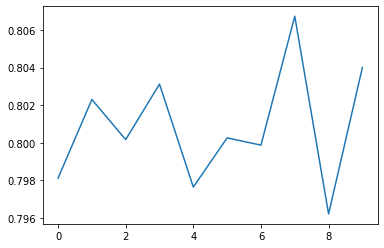

In [55]:
plt.plot(accuracy_array)

In [56]:
np.mean(accuracy_array)

0.800843734400613